In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from bb_rhythm import rhythm

## Compute phases of individual agents

In [59]:
def sliding_window_fitting(X, Y, agent_id, n_timesteps, period, param='phase'):
    
    fit_params = []
    
    for t in range(int(n_timesteps / period - 2)):

        subset_x = X[period * t : period * (t+3)]
        subset_y = Y[period * t : period * (t+3)]

        # Check if data is non-constant
        if np.ptp(subset_y) != 0:

            fit_data = rhythm.fit_cosinor_per_bee(subset_x, subset_y, period)
            if fit_data['p_value'] < 0.05:
                fit_params.append([agent_id, t, fit_data[param]])
            
    return fit_params
                
    
def get_daily_phases_for_agents(speeds, save_to='agents_phases.pkl'):
    
    phase_ls = []
    period = 400
    n_timesteps = speeds.shape[1]
    
    # Create time index where zero corresponds to 12 noon.
    t_index = np.arange(speeds.shape[1]) - period/4
    
    for agent_id in range(speeds.shape[0]):
        
        # Get speeds timeseries of current agent.
        agent_ts = speeds[agent_id]
        
        agent_phases = sliding_window_fitting(t_index, agent_ts, agent_id, n_timesteps, period)
        phase_ls.extend(agent_phases)
    
    result_df = pd.DataFrame(phase_ls, columns=['agent_id', 'day', 'phase'])
    result_df.to_pickle(save_to)
    return result_df


densities = [0.5, 1.0, 1.25, 1.50, 1.75, 2.0, 3.0, 5.0, 7.0]

for density in densities:
    sim_output = loadmat(f'output/OUT_density_{density:.2f}.mat')
    speeds = sim_output['OUT'][0][0][0]
    
    agents_daily_phases = get_daily_phases_for_agents(speeds, save_to=f'output/agents_phases_{density}.pkl')

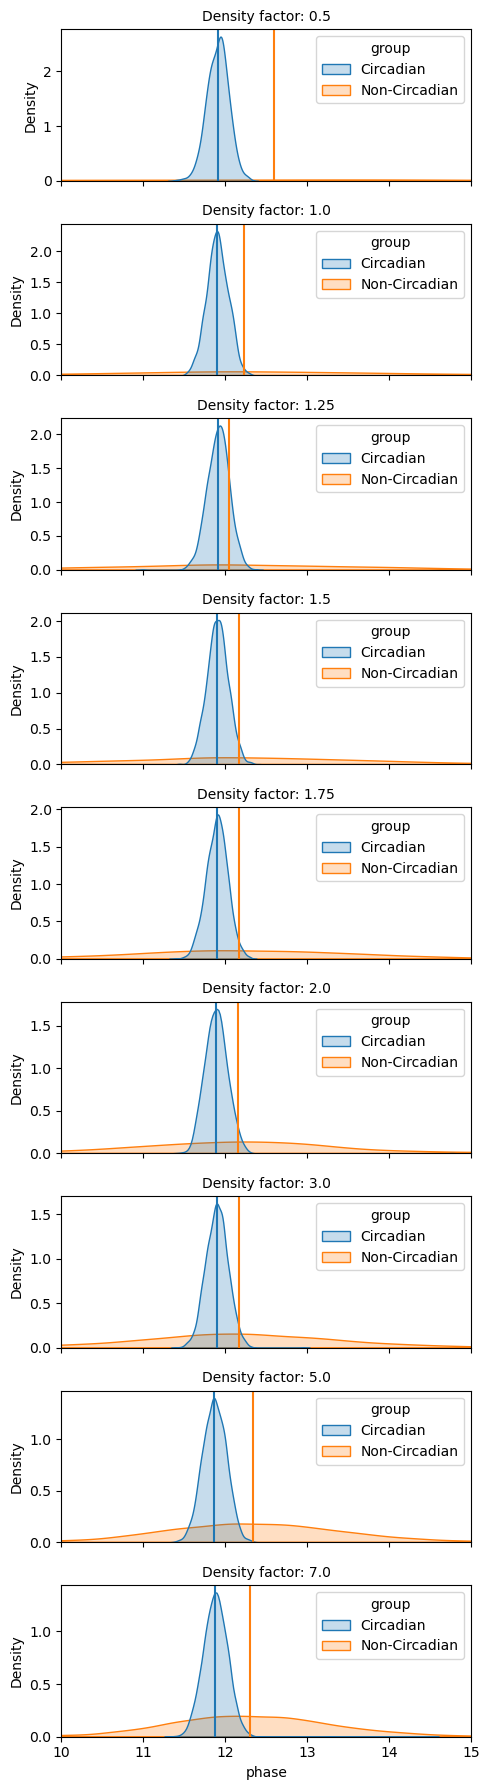

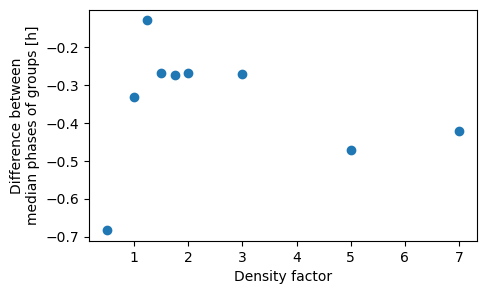

In [95]:
def convert_phase_to_hours(phase, period):
    return - period * phase / (2 * np.pi) * (24 / period) + 12

def get_phase_diff_indiv_fits(agg_func, plot_dist=False):
    densities = [0.5, 1.0, 1.25, 1.50, 1.75, 2.0, 3.0, 5.0, 7.0]
    phase_diffs = []

    if plot_dist:
        fig, ax = plt.subplots(len(densities),1,figsize=(5,2*len(densities)), sharex=True)
        
    for i, density_factor in enumerate(densities):
        agent_phases = pd.read_pickle(f'output/agents_phases_{density_factor}.pkl')
        agent_phases.loc[:, 'phase'] = convert_phase_to_hours(agent_phases['phase'], period=400)
        
        # Assign 0 to circadian group and 1 to non-circadian.
        agent_phases['group'] = (agent_phases.agent_id > 500 * density_factor).astype(int)
        
        # Compute mean/median phase per group.
        phase_g0 = agg_func(agent_phases.loc[agent_phases.group == 0, 'phase'])
        phase_g1 = agg_func(agent_phases.loc[agent_phases.group == 1, 'phase'])
        phase_diffs.append(phase_g0 - phase_g1)
        
        if plot_dist:
            agent_phases.loc[:,'group'] = agent_phases.loc[:,'group'].replace({0:'Circadian', 1:'Non-Circadian'})
            sns.kdeplot(data=agent_phases, x='phase', hue='group', ax=ax[i], fill=True)
            ax[i].set_title(f'Density factor: {density_factor}', fontsize=10)
            ax[i].axvline(phase_g0, color='tab:blue')
            ax[i].axvline(phase_g1, color='tab:orange')
            ax[i].set_xlim(10, 15)
        plt.tight_layout()

    label = 'median' if agg_func == np.median else 'mean'
    plt.figure(figsize=(5,3))
    plt.scatter(densities, phase_diffs)
    plt.xlabel('Density factor')
    plt.ylabel(f'Difference between\n{label} phases of groups [h]')
    plt.show()

get_phase_diff_indiv_fits(np.median, plot_dist=True)

<Figure size 640x480 with 0 Axes>

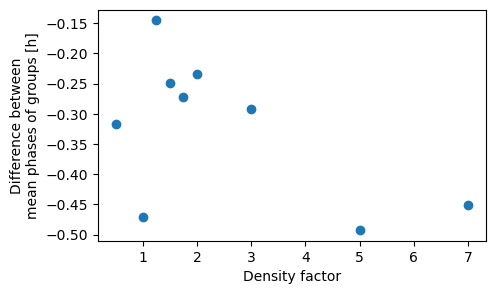

In [96]:
get_phase_diff_indiv_fits(np.mean)

## Aggregate speeds of all agents per group and the fit cosinor

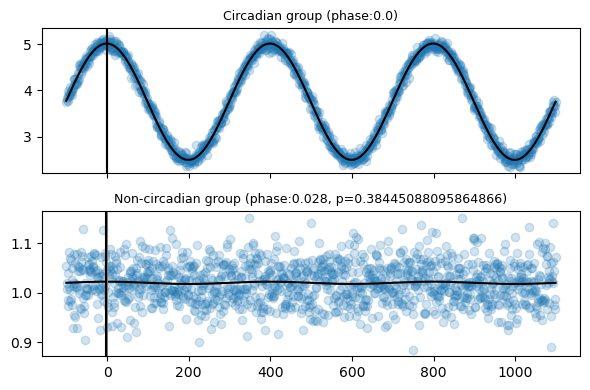

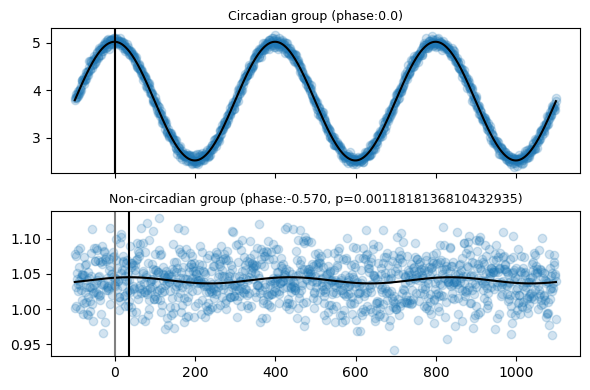

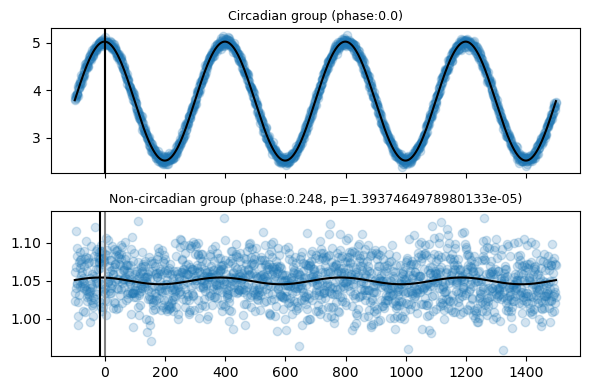

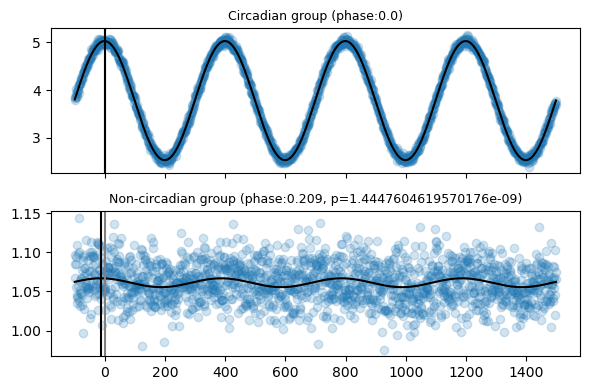

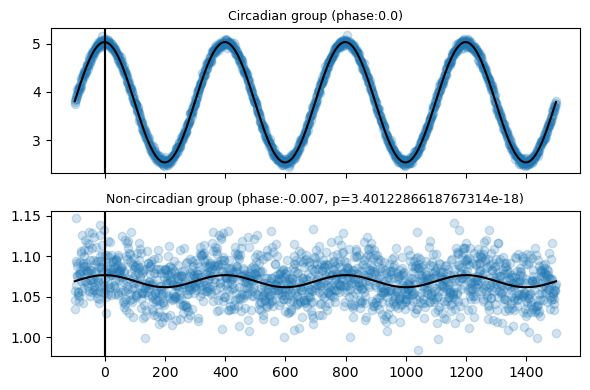

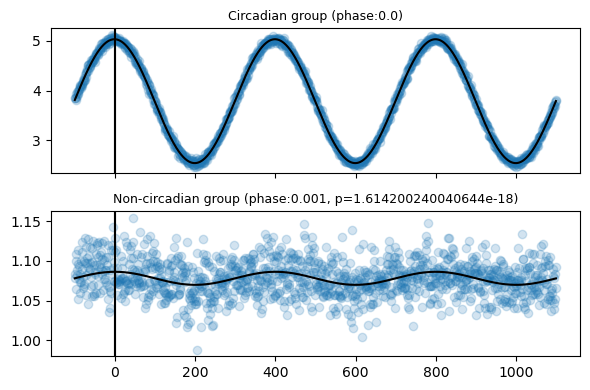

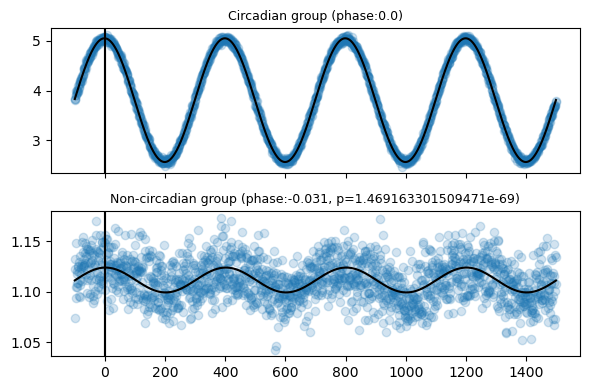

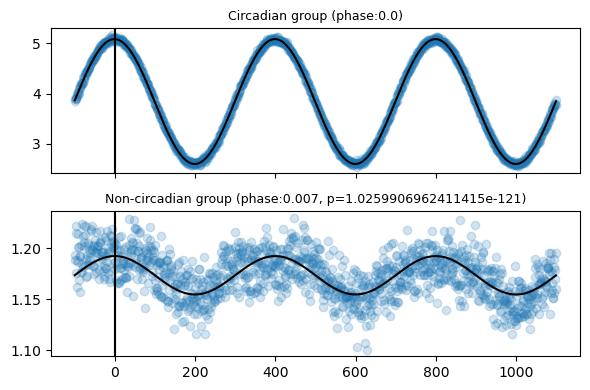

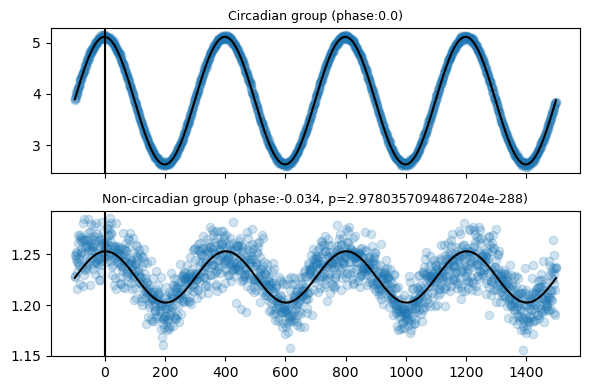

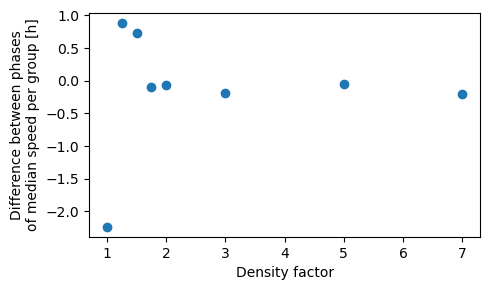

In [97]:
def aggregate_then_fit(agg_func, plot_fit=False):
    densities = [0.5, 1.0, 1.25, 1.50, 1.75, 2.0, 3.0, 5.0, 7.0]
    phase_diffs = []

    for density in densities:
        sim_output = loadmat(f'output/OUT_density_{density:.2f}.mat')
        speeds = sim_output['OUT'][0][0][0]
        
        # Compute mean/median speed per group.
        speed_g0 = agg_func(speeds[:int(500 * density)],axis=0)[400:]
        speed_g1 = agg_func(speeds[int(500 * density):],axis=0)[400:]
        
        # Fit cosinor to each group.
        period = 400
        t_index = np.arange(speed_g0.shape[0]) - period/4
        fit_g0 = rhythm.fit_cosinor_per_bee(t_index, speed_g0, period)
        fit_g1 = rhythm.fit_cosinor_per_bee(t_index, speed_g1, period)
        pval= fit_g1['p_value']
        
        if plot_fit:
            curve_g0 = rhythm.circadian_cosine(t_index, fit_g0['amplitude'],
                                               fit_g0['phase'], fit_g0['mesor'],
                                               period=period)
            curve_g1 = rhythm.circadian_cosine(t_index, fit_g1['amplitude'],
                                               fit_g1['phase'], fit_g1['mesor'],
                                               period=period)
            phase_g0 = fit_g0['phase']
            phase_g1 = fit_g1['phase']
            
            fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
            axs[0].scatter(t_index, speed_g0, alpha=0.2)
            axs[0].plot(t_index, curve_g0, color='k')
            axs[0].set_title(f'Circadian group (phase:{phase_g0:.1f})', fontsize=9)
            axs[0].axvline(0, color='gray')
            axs[0].axvline(t_index[np.argmax(curve_g0)], color='k')
            
            axs[1].scatter(t_index, speed_g1, alpha=0.2)
            axs[1].plot(t_index, curve_g1, color='k')
            axs[1].set_title(f'Non-circadian group (phase:{phase_g1:.3f}, p={pval})', fontsize=9)
            axs[1].axvline(0, color='gray')
            axs[1].axvline(t_index[np.argmax(curve_g1)], color='k')
            plt.tight_layout()
        
        # Get absolute difference in phases.
        if pval <= 0.05:
            phase_diffs.append(convert_phase_to_hours(fit_g0['phase'], period) - convert_phase_to_hours(fit_g1['phase'], period))
        else:
            phase_diffs.append(np.nan)


    label = 'median' if agg_func == np.median else 'mean'
    plt.figure(figsize=(5,3))
    plt.scatter(densities, phase_diffs)
    plt.xlabel('Density factor')
    plt.ylabel(f'Difference between phases\nof {label} speed per group [h]')
    plt.tight_layout()
    # plt.savefig(label + '.png')
    plt.show()

aggregate_then_fit(np.median, plot_fit=True)

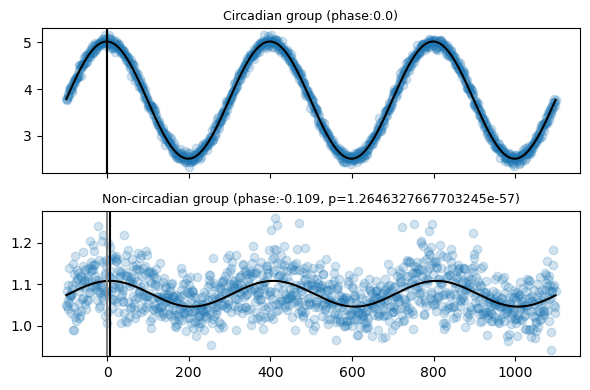

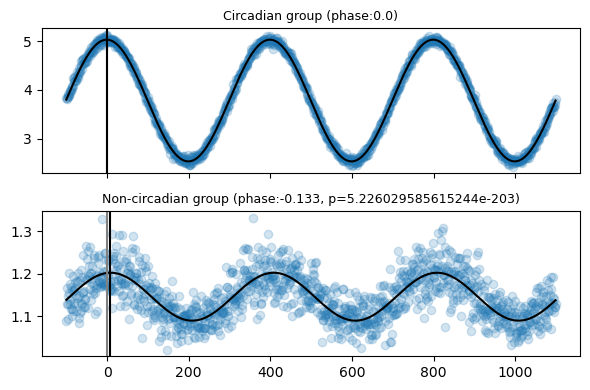

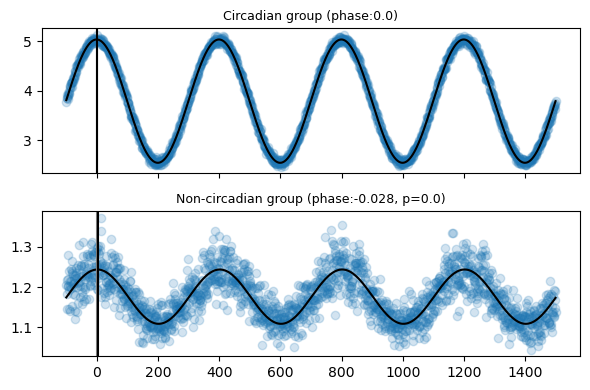

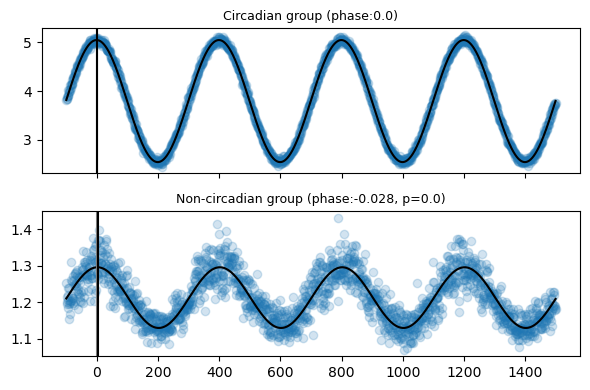

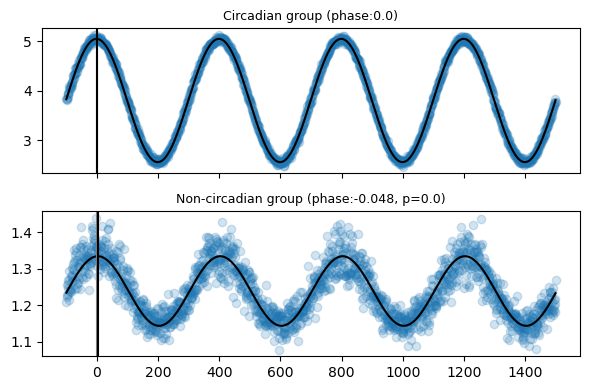

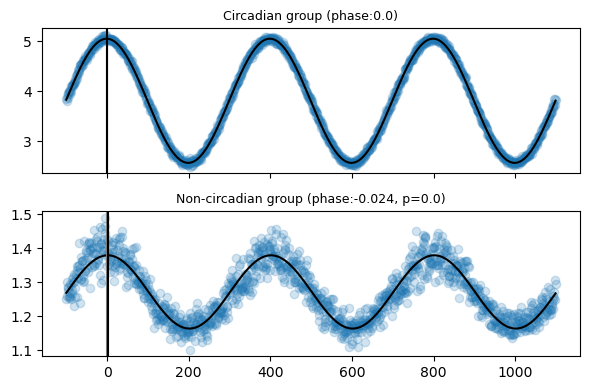

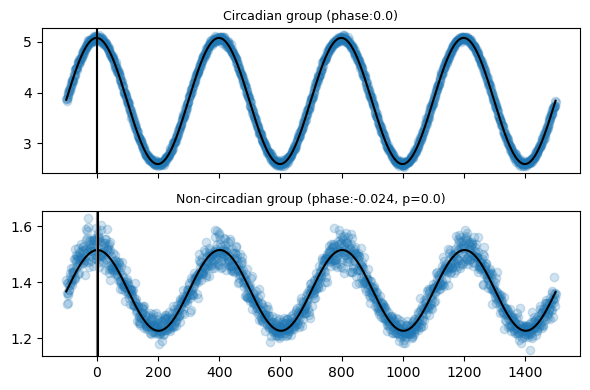

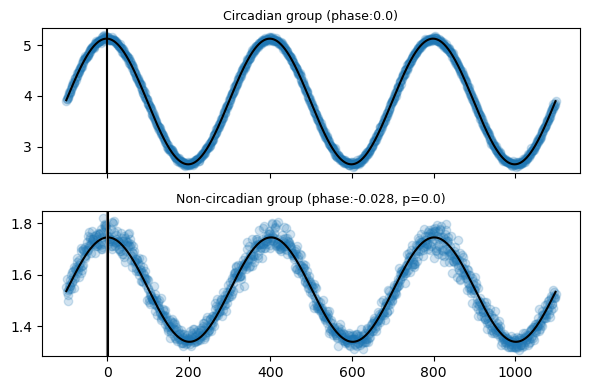

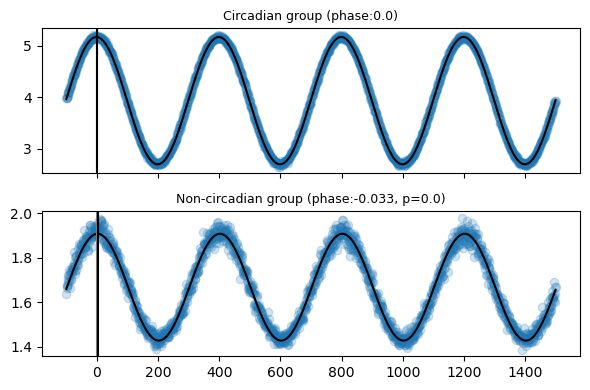

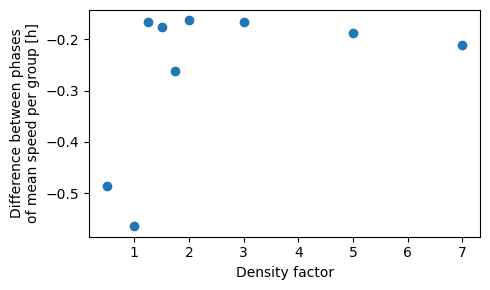

In [98]:
aggregate_then_fit(np.mean, plot_fit=True)